# Homework 5 - Explore Wikipedia's hyperlinks network

Useful libraries

In [1]:
import pandas as pd
import numpy as np
import re
import random
from random import randint
from random import seed
import math
import networkx as nx
import matplotlib.pyplot as plt

In [123]:
import modules_hw5 as mod

Import the dataset

In [3]:
dataset = pd.read_csv('wikigraph_reduced.csv', sep='\t', 
                      delimiter=None, header='infer',
                      names=None, index_col=None, 
                      usecols=None, 
                      encoding = "ISO-8859-1")

In [4]:
dataset.head()

,Unnamed: 0,0,1
0,796,95,1185516
1,909,108,1059989
2,910,108,1062426
3,911,108,1161925
4,1141,134,541222


In [5]:
dataset.columns

Index(['Unnamed: 0', '0', '1'], dtype='object')

Change the columns name; 0 is the **source** and 1 is the **target**

In [6]:
dataset.columns=['Index','Source','Target']

Make the first column the index

In [7]:
dataset.set_index('Index' , inplace = True)

In [8]:
dataset.head()

,Source,Target
Index,,
796,95,1185516
909,108,1059989
910,108,1062426
911,108,1161925
1141,134,541222


### RQ1. Create the graph
Create two dictionaries for the nodes of the graph; one is for the indegree node, the other one is for the outdegree node. Note that the dictionaries contain the unique element.

In [9]:
in_degree = {v: [] for v in set(dataset.Source)}
out_degree = {v: [] for v in set(dataset.Target)}

In [10]:
for row in dataset.iterrows():
    source = row[1][0]
    target = row[1][1]
    in_degree[source].append(target)
    out_degree[target].append(source)

Visualize how many *in link* and *out link* has the graph

In [11]:
n_art_outlink = len(out_degree)
print(n_art_outlink)

75467


In [12]:
n_art_inlink = len(in_degree)
print(n_art_inlink)

90920


#### Is the graph directed?

In [13]:
if (len(set(dataset.Source).intersection(set(dataset.Target)))!=0):
     print ('The graph is directed')

The graph is directed


#### How many articles are we considering?

In [14]:
#In the variable below we save all the articles that compose the graph
nodes = set(dataset.Source).union(set(dataset.Target))
n_nodes = len(nodes)
print(n_nodes)

98343


#### How many hyperlinks between pages exist?

In [15]:
n_edges = len(dataset)
print(n_edges)

483094


#### Compute the average number of links in an arbitrary page

In [16]:
n_outlinks = []
for node in nodes:
    try:
        out_deg = len(out_degree[node])
    except:
        out_deg = 0
    n_outlinks.append(out_deg)
avg_outlink = np.mean(n_outlinks)
print('The average number of outlinks in a page is: ',round(avg_outlink))

The average number of outlinks in a page is:  5


#### What is the graph density?
For directed graph the density is given by: $$\frac{|E|}{|V|(|V|-1)}$$



In [17]:
density = (n_edges/(n_nodes*(n_nodes-1)))
print(density)

4.9951571365597335e-05


#### The graph is dense or sparse?

Since the value of the density of our graph is very low, we can assume that our graph is **sparse**.

In [18]:
print('Max number of edges:',n_nodes**2)
print('Number of edges: ',n_edges)

Max number of edges: 9671345649
Number of edges:  483094


#### Visualize the nodes' degree distribution

At first we save the connections of each node into a list, then we store that list into a pandas Series in order to plot it.

In [19]:
connections = []
for node in nodes:
    try:
        in_deg = len(in_degree[node])
    except:
        in_deg = 0
    try:
        out_deg = len(out_degree[node])
    except:
        out_deg = 0
    connections.append(in_deg+out_deg)

In [20]:
series=pd.Series(connections)
degrees=series.groupby(by=connections).count()
d_sum=np.sum(degrees)
# the first 50 degrees values are enough to give a true representation
degrees=degrees[0:50]   
degrees=degrees/d_sum

degrees_sum=0
cdf_list=[]
for x in degrees:  
    degrees_sum=(degrees_sum+x)   
    cdf_list.append(degrees_sum)

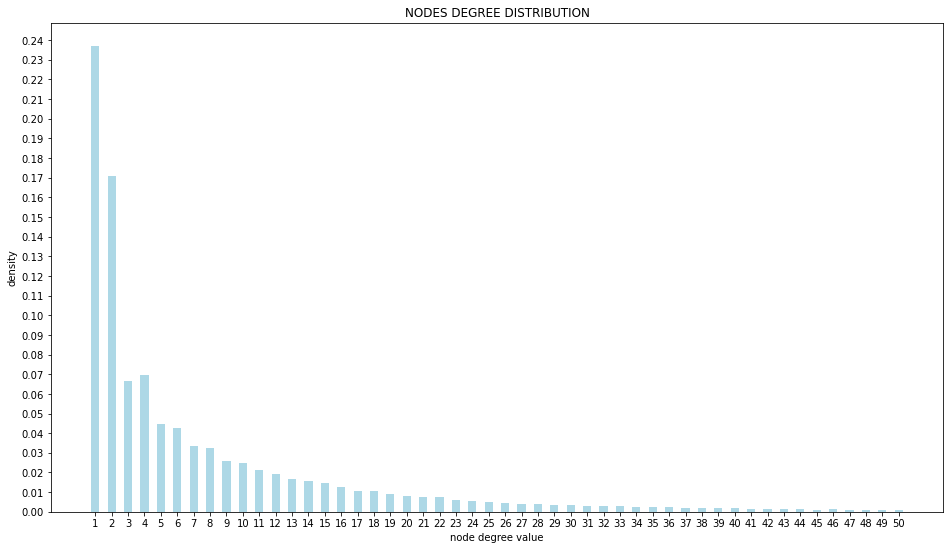

In [21]:
plt.figure(figsize=(16,9));
plt.xticks(np.arange(1,51,1));
plt.yticks(np.arange(0,1,0.01));
plt.xlabel('node degree value');
plt.ylabel('density');
plt.title('nodes degree distribution'.upper());
plt.bar(degrees.index,degrees,color='lightblue',width=0.5);

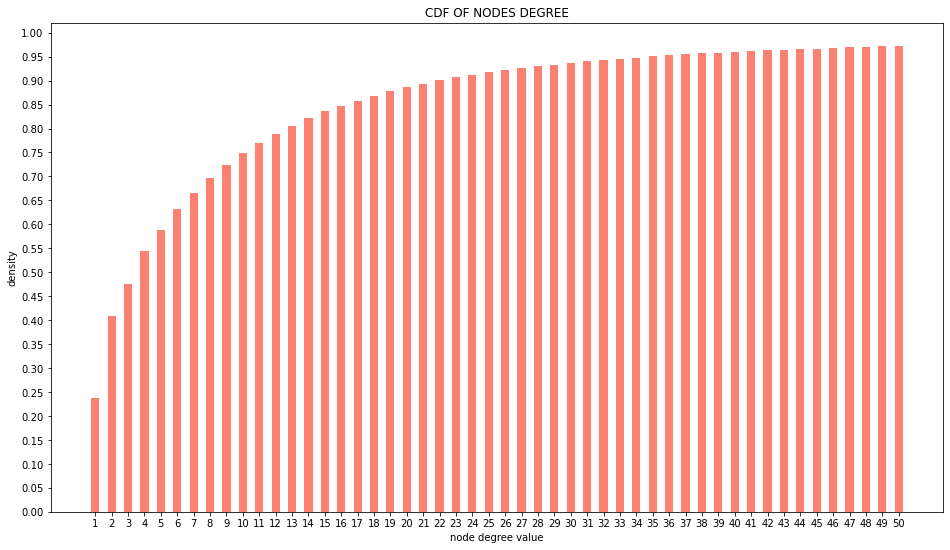

In [22]:
plt.figure(figsize=(16,9));
plt.xticks(np.arange(1,51,1));
plt.yticks(np.arange(0,1.05,0.05));
plt.xlabel('node degree value');
plt.ylabel('density');
plt.title('CDF of nodes degree'.upper());
plt.bar(degrees.index,cdf_list,color='salmon',width=0.5);

#### Importing file of page's names

In [23]:
f_pages=open('wiki-topcats-page-names.txt','r')
names=list(f_pages.readlines())

In [24]:
page_names=mod.text_fix(names)

#### Importing file of categories 

In [25]:
f_cat=open('wiki-topcats-categories.txt','r')
cat=list(f_cat.readlines())
l=cat[0].split(' ')

Once we have the imported file, from this we create 2 dictionaries:
* **categories** is a dictionary with key = node; value = category
* **categories_file** is the same dictionary but with the inverted arguments, like the file's structure: key= category; value = nodes

In [26]:
categories, categories_file=mod.categories_building(cat,nodes)

In [27]:
print(categories[1000831])#giving a page we can see the related category
print()
print(categories_file['Eli_Lilly_and_Company']) #giving a category we can see the associated pages

['Rivers_of_Hunedoara_County', 'Rivers_of_the_Mure_subbasin', 'Rivers_of_Romania']

[948021, 1055485, 1164028, 1715998]


### Filter the category dictionaries:
#### "In the case of multiple appearance, you break the ties uniformly at random"
*categories_filtered* is the new dictionary containing the filtered *categories*.

In [28]:
categories_filtered={}
seed(34)
for node in categories.keys():
    try:
        rand_category = random.choice(categories[node])
        categories_filtered[node] = rand_category
    except:
        categories_filtered[node] = 'Nan'

In [29]:
#print(categories_filtered.keys())

*categories_file_filtered* is the new dictionary containing the filtered *categories_file* but with key = category and values = nodes.

In [30]:
categories_file_filtered = {category:[] for category in set(categories_filtered.values())}
for node in categories_filtered.keys():
    try:
        categories_file_filtered[categories_filtered[node]].append(node)
    except:
        continue

In [31]:
#before filtering:
print(categories_file['Upcoming_films'])

[153, 71350, 71574, 113250, 123438, 137563, 144751, 152836, 170043, 258109, 271126, 296133, 343203, 351575, 355726, 358607, 358687, 373459, 395586, 402971, 418342, 419902, 427505, 427985, 430122, 430663, 436016, 468579, 469894, 499883, 501391, 501465, 559711, 573762, 581243, 581515, 581584, 581593, 581735, 581761, 581782, 582203, 582429, 582443, 582473, 582505, 582547, 583054, 583061, 583072, 583082, 583088, 583104, 583125, 583166, 583320, 583517, 583614, 583616, 583626, 583792, 583797, 583871, 583989, 584081, 584086, 584124, 584232, 584235, 584256, 584291, 584293, 584297, 584317, 584600, 584623, 584672, 584726, 584759, 584769, 584791, 584794, 584919, 585019, 585344, 585449, 585756, 586443, 586448, 586493, 586498, 586502, 586622, 586723, 587360, 587465, 587987, 588122, 588124, 588150, 588231, 588618, 591621, 594726, 605617, 610922, 627149, 629539, 631611, 634276, 637607, 672902, 675292, 676445, 710618, 711466, 711633, 716911, 724842, 724863, 724874, 725185, 733940, 741002, 743648, 7437

In [32]:
#After filtering:
print(categories_file_filtered['Upcoming_films'])

[1048648, 153, 1049526, 1052907, 1054743, 1054911, 1054940, 1056868, 1064893, 1589342, 1068411, 1070434, 1079561, 1080822, 559711, 1085699, 1619029, 1622974, 581243, 581515, 582443, 583088, 583125, 583989, 584081, 584232, 584291, 584726, 585756, 1110229, 586443, 586493, 586498, 586502, 586622, 587987, 588124, 588618, 591621, 71350, 1151251, 629539, 1678376, 1585777, 1067515, 1701415, 676445, 716911, 724874, 1263905, 775038, 775182, 258109, 800238, 800507, 355726, 358607, 893027, 395586, 922638, 402971, 427985, 430663, 436016, 960738, 971349, 1508226, 1015666, 1034852, 1040912, 1770633, 1048248]


## RQ2
Define a function that takes in input:

- A page v
- A number of clicks d


and returns the set of all pages that a user can reach within d clicks.

In [33]:
#seed for random number generator
seed(3)
#select a random number of click in a range (1,6)
d = randint(1,6)
print('Number of clicks: ', d)
#pick a random page in the out_degree dictionary
v = random.choice(list(out_degree.values())[1])
print('Page: ',v)
#the count starts from 1 
result = mod.clicks(d,1,[v],[],out_degree) 

Number of clicks:  2
Page:  786432


In [34]:
print('Set of pages: ',set(result))

Set of pages:  {786432, 786433, 1622420, 787486, 1622313, 787374, 787377, 1622321, 785340, 999877, 786381, 786382, 786383, 786384, 786385, 786386, 786387, 786388, 787539, 787290, 783579, 787552, 1622647, 785517, 787822, 786295, 786424, 1000831}


## RQ3
Define a function that takes in input:

- A category C
- A set of pages in C, p = {p1, ..., pn}


and returns the minimum number of clicks required to reach all pages in p, starting from the page v, corresponding to the most central article, according to the in-degree centrality, in C. 

Definition of the input of our algorithm:

In [35]:
C = 'Rivers_of_Hunedoara_County'
p = list(categories_file_filtered[C])

C1 = 'Upcoming_films'
p1 = list(categories_file_filtered[C1])

Firstly we compute the **indegree centrality** in order to find the most central article **v** in the set of pages in the given category C. We use a dictionary in_deg_centr that has as key the node and as value its centrality computed with the formula:
$$ \frac{d_c(v)}{n-1}$$

In [36]:
def define_v(n_list):
    #initialization of the variables
    centrality = 0
    central_node = 0
    in_deg_centr = {}
    for node in n_list:
        try:
            centrality = len(in_degree[node])
            #compute the indegree centrality -> key = node, value = indegree centrality
            in_deg_centr[node] = centrality/(len(in_degree)-1)
        except:
            continue
    # Sort dictionary by value in ascending order using lambda function
    sorted_dict = dict(sorted(in_deg_centr.items(),key=lambda item: item[1],reverse=True))
    #the first item is the node with max indegree centrality
    central_node = list(sorted_dict.keys())[0]
    return (central_node)

In [37]:
print('For the list: ', p, '\nThe central node is: ',define_v(p))
print()
print('For the list: ', p1, '\nThe central node is: ',define_v(p1))

For the list:  [217763, 1622352, 1622445, 1622627, 1622647, 1622739, 1622741, 1622742, 1622743, 1622745, 1622747, 1622749, 1622750, 1622751, 1622775, 72133, 72144, 1672029, 1687141, 1686680, 1686705, 1687936, 1688025, 1688032, 1688036, 1688037, 722104, 722195, 722378, 722429, 722539, 217762, 783558, 783618, 783710, 783721, 783759, 784113, 784118, 784127, 784185, 784186, 784189, 784317, 784327, 784329, 784353, 784988, 785010, 785152, 785276, 785280, 785340, 785360, 785421, 785440, 785515, 785517, 785518, 785626, 785737, 785738, 785740, 785758, 785779, 785780, 785802, 785830, 785853, 785859, 785892, 785894, 785896, 785992, 786036, 786041, 786042, 786043, 786075, 786137, 786221, 786222, 786238, 786294, 786296, 786304, 786307, 786310, 786373, 786375, 786380, 786387, 786389, 786392, 786394, 786397, 786398, 786402, 786415, 786417, 786418, 786424, 786429, 786622, 786623, 786624, 786625, 786628, 786629, 786632, 786636, 786637, 786743, 786773, 786775, 786948, 786953, 786957, 787098, 787103, 787

With the function below we compute the *minimum distances* from a starting node and all the vertexes that belongs to the ***out_degree*** dictionary. \
This function is based on the idea of the BFS, that explores a graph givin a source node and  computes the shortest path between the nodes according to the number of edges instead of the weight. \
The main idea is to start from the most central article and explore the graph of the out degree, and to go always to the node that is closest to the source one. \
So in each iteration: 
* We extract a node from the queue that has the shortest distance from the source node
* We visit all the neighbors of the extracted node and check the new distance we were able to achieve
    - If we didn't explore that node yet, we update the distance of this node and push it to the queue. 
* Then the algorithm continues until the queue is empty.

Since we are dealing with edges that has weight equal to 1, we are sure that all the direct neighbors of the source node have a distance equal to one and that all the second neighbors of the source node have a distance equal to two, and so on. \
But in the case we reached a node that has been visited before, we have to ignore it since we must have reached it with a shorter path before. \
At the end we return a dictionary where the key is the node and the value is the minimum number of links (the distance) between the most central article and that node.

In [38]:
def shortest_path(subgraph,start_vertex):
    queue=[]
    queue.append(start_vertex)
    dist={} 
    #the distance between the start_vertex and itself is 0
    dist[start_vertex]=0
    visited={vertex:False for vertex in subgraph.keys()}
    visited[start_vertex]=True
  
    while not len(queue)==0:
        count=0
        #extract a vertex from the queue and explore it
        vertex=queue.pop(0)
                     
        for neighbour in subgraph[vertex]:          
            try:
                if visited[neighbour]==False:                   
                    visited[neighbour]=True
                    #increase the distances by 1
                    dist[neighbour]=dist[vertex]+1
                    #add the node in the queue
                    queue.append(neighbour)
            except KeyError:
                continue
    return dist

In order to define the minimun number of clicks, the *heuristic solution* we provide is to consider the path you should follow to **reach a page from a starting node and to go back to the starting point**. \
In case the page isn't reacheable from v, then the function give in output the string "Not possible" and indicates for which page in the list there isn't a path.

In [39]:
def num_clicks(page_list):
    #save all the node and the distances that v can reach
    distances_dict = shortest_path(out_degree,define_v(page_list))
    min_clicks = 0
    #initialize the list of pages reached from v
    dist_page = []
    #remove the item that has '0' as value (because it's the starting node) 
    distances_zero = {key:val for key, val in distances_dict.items() if val != 0}
    #remove as well the starting node from the list of pages p
    page_list.remove(define_v(page_list))
    #iterate trought the list p in input
    for pg in page_list:
        #append in the list only the pages reached from v
        if distances_zero.get(pg) is not None:
            dist_page.append(pg)
        else:
            #otherwise, handle the case where not all the pages in p are reachable from v
            print('Not possible for page: ', pg)
    
    for page in dist_page[:-1]:
        print('Page: ',page,' distance from v: ',distances_zero[page])
        min_clicks += distances_zero[page]*2 #to go and back

    min_clicks += distances_zero[dist_page[-1:][0]]
    return min_clicks

Here we provide some examples using different categories. \
As we can see, not all the pages in the list p are reached from v, but for those with which the page v is connected, the distance has a small value. It's reasonable since the pages belong to the same category.

In [40]:
num_clicks(p)

Not possible for page:  72133
Not possible for page:  785010
Not possible for page:  785152
Not possible for page:  785518
Not possible for page:  785737
Not possible for page:  785740
Not possible for page:  785779
Not possible for page:  785780
Not possible for page:  785992
Not possible for page:  787324
Not possible for page:  787325
Not possible for page:  787742
Not possible for page:  787786
Not possible for page:  787952
Page:  217763  distance from v:  10
Page:  1622352  distance from v:  6
Page:  1622445  distance from v:  6
Page:  1622627  distance from v:  5
Page:  1622647  distance from v:  5
Page:  1622739  distance from v:  7
Page:  1622741  distance from v:  7
Page:  1622742  distance from v:  7
Page:  1622743  distance from v:  7
Page:  1622745  distance from v:  7
Page:  1622747  distance from v:  7
Page:  1622749  distance from v:  7
Page:  1622750  distance from v:  7
Page:  1622751  distance from v:  7
Page:  1622775  distance from v:  2
Page:  72144  distance from

1677

In [41]:
num_clicks(p1)

Not possible for page:  1080822
Not possible for page:  559711
Not possible for page:  1622974
Not possible for page:  581243
Not possible for page:  581515
Not possible for page:  583125
Not possible for page:  584081
Not possible for page:  584232
Not possible for page:  584291
Not possible for page:  584726
Not possible for page:  585756
Not possible for page:  586443
Not possible for page:  586493
Not possible for page:  586502
Not possible for page:  586622
Not possible for page:  588124
Not possible for page:  588618
Not possible for page:  591621
Not possible for page:  71350
Not possible for page:  1151251
Not possible for page:  629539
Not possible for page:  258109
Not possible for page:  800238
Not possible for page:  800507
Not possible for page:  358607
Not possible for page:  430663
Not possible for page:  960738
Not possible for page:  1015666
Not possible for page:  1770633
Page:  1048648  distance from v:  5
Page:  153  distance from v:  5
Page:  1049526  distance from

344

## RQ4

**In the following cells there is a modification of the dictionary keys for further operations**

In [42]:
d=mod.transform_dict(categories_file_filtered)


**in this cell two categories are asked in input** 

In [43]:
all_pages=mod.categories_input(d)

insert the first category: American films
insert the second category: American film actors


In [182]:
print(all_pages[1:100])


[147467, 1753103, 1245201, 688149, 1245208, 639007, 655392, 147492, 639014, 1163309, 1654833, 1065009, 1163315, 147508, 1261624, 1507388, 1048638, 1245249, 1163330, 1130568, 1163338, 1065036, 1163340, 1245264, 1048660, 1163348, 1163358, 1261665, 295016, 901225, 1245290, 688249, 1245310, 1048703, 1065090, 393356, 1245326, 770192, 1048722, 770194, 1622164, 1048723, 1048735, 1163425, 1065124, 688292, 1245348, 1048745, 688300, 173, 1245363, 1065142, 1065144, 1245370, 1130683, 1163453, 1163455, 901316, 1163462, 1245384, 1130702, 1245393, 1048787, 901335, 1048792, 1048798, 1065184, 393440, 1065187, 1130724, 1179875, 1278182, 1261800, 1179883, 1163501, 1163504, 1065201, 1278194, 1048819, 147699, 147705, 475387, 1163520, 1376513, 311554, 1278213, 1163525, 1261832, 213258, 1065228, 1179925, 1065238, 1048855, 1048857, 344345, 213277, 639262, 1163554, 1278246]


In [45]:
#in the following cell, when the page is asked in input, please insert all characters in lower case.

In [147]:
input_pages=mod.input_pages(all_pages,page_names)

insert the first page victor lundin
insert the second page the lion and the lamb


**creating the out_degree subgraph of the two categories given in input. This graph will include only pages which belong to the two categories**

In [47]:
out_d=mod.out_subgraph(all_pages,out_degree,d)

In [48]:
#out_d

**creating the in_degree subgraph of the two categories given in input. This graph will include only pages which belong to the two categories**

In [49]:
in_d=mod.in_subgraph(all_pages,in_degree,d)

In [50]:
#in_d

**in this section, for each couple of pages taken into account, it will be found the minimum set of pages to remove in order disconnect the two pages**

*test1 using two random pages*

In [183]:
first_page=random.choice(all_pages)
print(first_page)

second_page=random.choice(all_pages)
print(second_page)

print(f'start page is: {page_names[first_page]}')

print(f'end page is: {page_names[second_page]}')

1269487
1162576
start page is: The Prisoner of Shark Island
end page is: Jeff York


*obtaining parents for the first page*

In [184]:
parents_1=in_d[first_page]
parents_1

[1665158]

*obtaining parents for the second page*

In [185]:
parents_2=in_d[second_page]
parents_2

[1048953, 1049383, 1247237]

*for each neighbour of the first page and of the second page it is calculated wheter it is connected with the end page or not. if there is no connection, the neighbour is not added to the set of pages to remove. Otherwise, if there exist a path between them, the neighbour will be added to the set to remove.*

In [186]:
d_parents={}
for parent in parents_1:

    d_parents[parent]=mod.links_remove(in_d,parent,second_page)
    
for parent in parents_2:
    
    d_parents[parent]=mod.links_remove(in_d,parent,first_page)
    
d_parents

{1665158: 'connected',
 1048953: 'connected',
 1049383: 'connected',
 1247237: 'connected'}

In [187]:
pages_to_remove=[]

for key,value in d_parents.items():
    
    if value=='connected':
        
        pages_to_remove.append(key)
        
if len(pages_to_remove)>0:
        
    print('the minimum set of nodes to remove in order to disconnect the two pages is ',pages_to_remove)
    
else:
    print('there are no connections among the two pages, so there is no set to remove')

the minimum set of nodes to remove in order to disconnect the two pages is  [1665158, 1048953, 1049383, 1247237]


*test 2 using input pages*

In [177]:
first_input=input_pages[0]
second_input=input_pages[1]

In [178]:
parents_1=in_d[first_input]
parents_1

[1049163]

In [179]:
parents_2=in_d[second_input]
parents_2

[1265864, 1268174, 1270312]

In [180]:
d_parents={}
for parent in parents_1:

    d_parents[parent]=mod.links_remove(in_d,parent,second_page)
    
for parent in parents_2:
    
    d_parents[parent]=mod.links_remove(in_d,parent,first_page)
    
d_parents

{1049163: 'connected',
 1265864: 'the starting page is connected with itself',
 1268174: 'the starting page is connected with itself',
 1270312: 'the first page has no connections among the pages of the two categories considered'}

In [181]:
pages_to_remove=[]

for key,value in d_parents.items():
    
    if value=='connected':
        
        pages_to_remove.append(key)
        
if len(pages_to_remove)>0:
        
    print('the minimum set of nodes to remove in order to disconnect the two pages is ',pages_to_remove)
    
else:
    print('there are no connections among the two pages, so there is no set to remove')

the minimum set of nodes to remove in order to disconnect the two pages is  [1049163]


## Rq5

In [153]:
#categories_file_filtered.keys()

In [154]:
input_cat=mod.cat_input(d)

insert a category American FILMSS actors
the category you are looking for is not in the categories considered or you wrote wrongly.
press any character if you want to continue, otherwise press a digit g
insert a category AMERICAN FILM ACTORS


In [159]:
new_lista=d[input_cat]
#print('the pages relative to the input category are: ')
#for number in new_lista:
    
    #print(page_names[number])

In [160]:
d_cat={key:[] for key in categories_file_filtered.keys()}

#d_cat

**in the following function will be used the previous dictionary, where each key is a category name, in order to store the distances from each page of the category input to the other pages of the other categories. For each key there will be an empty list if there are no links at all between the two categories or a list of distances among the single pages in the two categories**

In [161]:
d_cat=mod.dictionary_distances(mod.cat_distance,in_degree,new_lista,categories_filtered,d_cat)

100%|██████████| 2861/2861 [20:50<00:00,  2.29it/s]


**computing the median distance between category input and the others categories**

In [162]:
d_result=mod.median(d_cat)

**showing the categories distances from the input category, ordered by median**

In [163]:
series=pd.Series(data=d_result).sort_values()
series.head(30)

People_from_Odessa                                 2.0
Fandom                                             2.0
American_people_of_Ukrainian-Jewish_descent        3.0
Harvard_University_people                          3.0
United_States_Navy_officers                        3.0
American_conservationists                          3.0
Australian_people_of_Irish_descent                 3.0
American_documentary_filmmakers                    3.0
American_people_of_Romanian-Jewish_descent         3.0
American_hip_hop_musicians                         3.0
American_health_activists                          3.0
People_from_Waco,_Texas                            3.0
History_of_the_United_States_(18651918)            4.0
Writers_from_Chicago,_Illinois                     4.0
American_anti-communists                           4.0
American_people_of_Hungarian-Jewish_descent        4.0
Emmy_Award_winners                                 4.0
United_States_National_Medal_of_Arts_recipients    4.0
American_p

In [164]:
series[-30:-1]

Lyngby_Boldklub_players                  11.0
Royal_Antwerp_FC_players                 11.0
Toluca_footballers                       11.0
Pescara_Calcio_players                   11.5
People_from_Plymouth                     12.0
A.S._Varese_1910_players                 12.0
A.C._Reggiana_1919_players               12.0
American_soccer_coaches                  12.0
2005_CONCACAF_Gold_Cup_players           12.0
Perth_Glory_FC_players                   12.0
F.C._Crotone_players                     12.0
U.S._Avellino_players                    12.0
A.S._Bari_players                        12.0
A.C._Siena_players                       13.0
Alumni_of_the_University_of_Sussex       13.0
South_Korea_international_footballers    13.0
People_from_Genoa_(city)                 13.0
Expatriate_footballers_in_Poland         13.0
South_Korean_expatriate_footballers      13.0
V2_Records_albums                        13.0
Jazz_fusion_albums                       13.0
1._FC_Kln_players                 

In [165]:
series.describe()

count    3795.000000
mean        6.210277
std         1.695734
min         2.000000
25%         5.000000
50%         6.000000
75%         7.000000
max        17.000000
dtype: float64

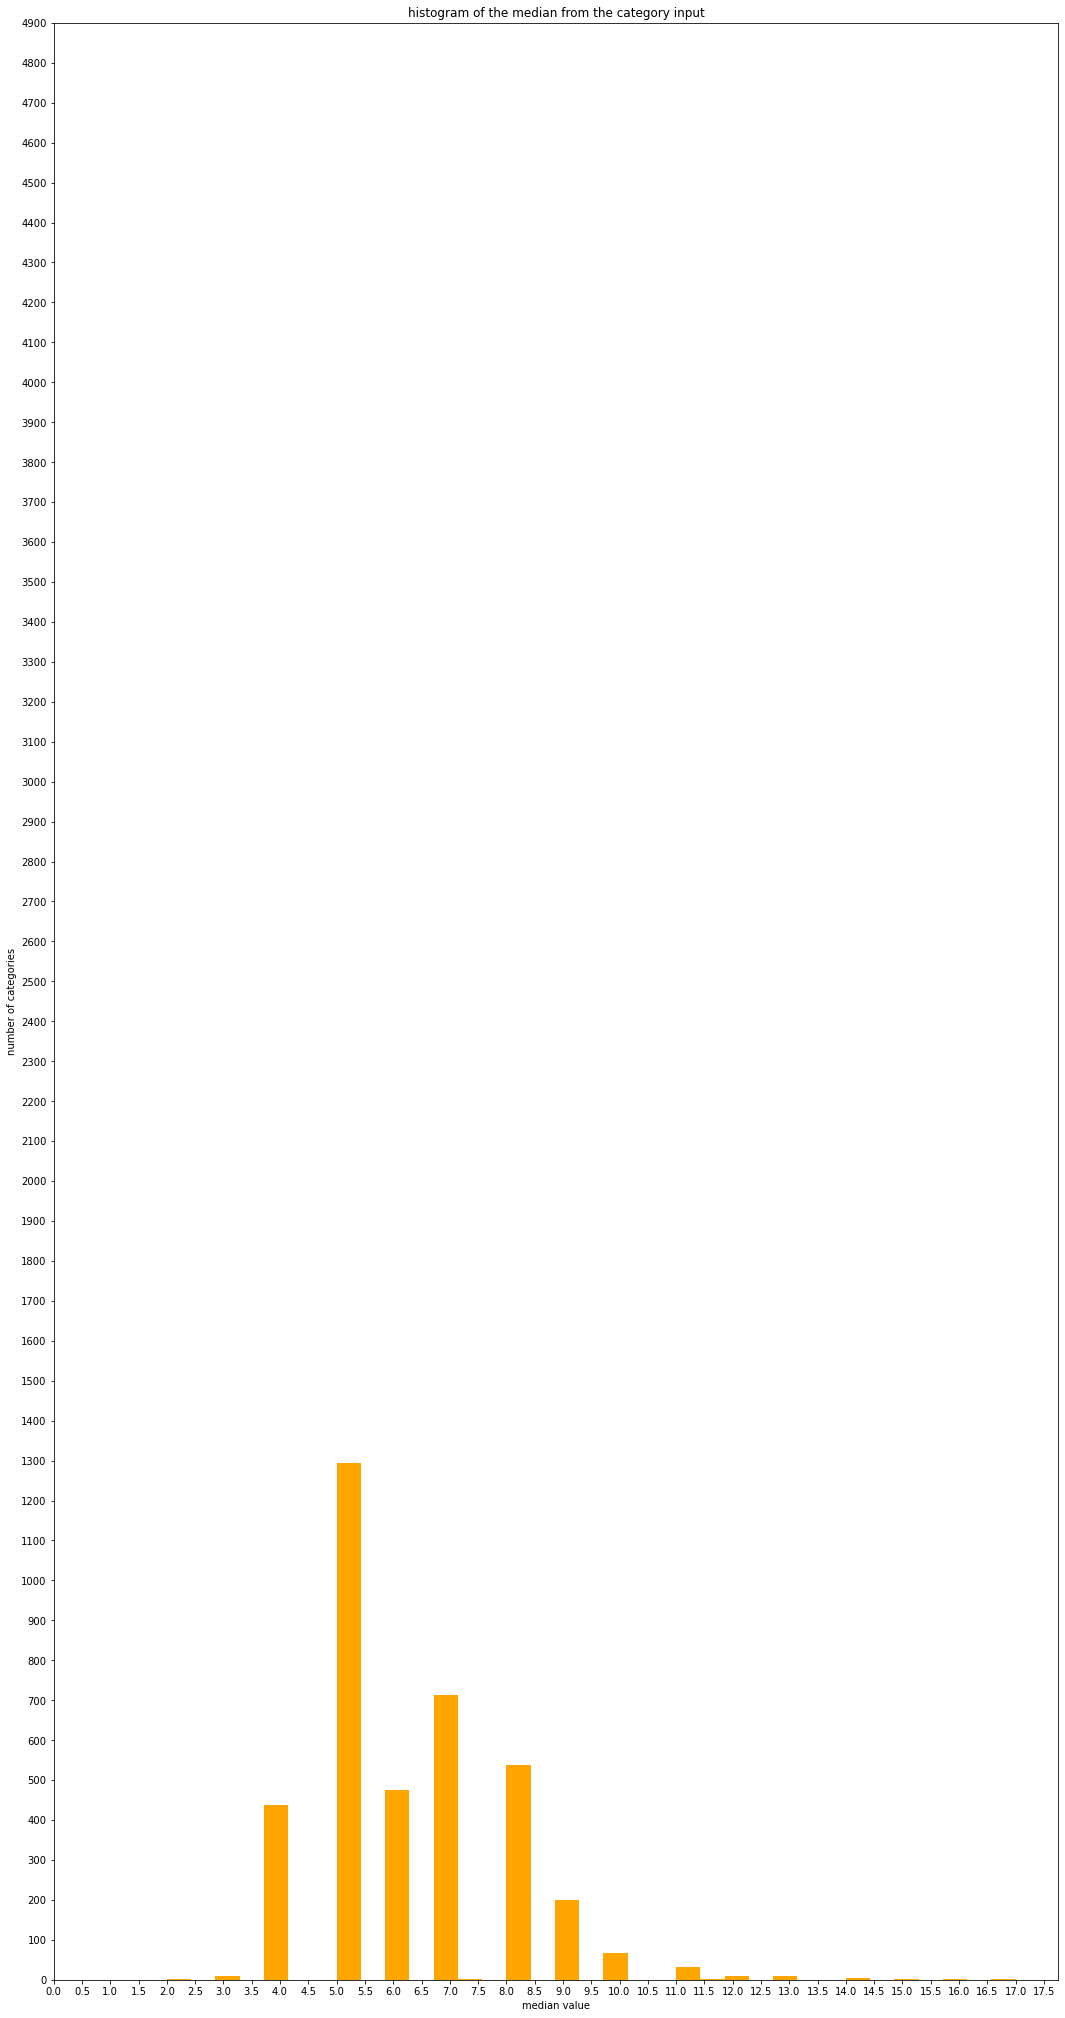

In [166]:
plt.figure(figsize=(18,36))

plt.title('histogram of the median from the category input')

plt.hist(series,color='orange',bins=35)

plt.xlabel('median value')

plt.xticks(np.arange(0,np.max(series)+1,0.5))

plt.yticks(np.arange(0,5000,100))

plt.ylabel('number of categories')


plt.show()

## RQ6

In [168]:
out = mod.sort_categories(categories_file_filtered)

In [171]:
out[1:100]

['S-type_asteroids',
 'A-League_players',
 'K-League_players',
 'C-type_asteroids',
 'F.B.C._Unione_Venezia_players',
 'A.C._Cesena_players',
 'F.C._Atlas_players',
 'J._League_Division_1_players',
 'U.S._Route_9',
 'A.S._Lucchese-Libertas_players',
 '1._FC_Kln_players',
 'A.C._Reggiana_1919_players',
 'R._Charleroi_S.C._players',
 'A.C._Milan_players',
 'S.S._Lazio_players',
 'A.C._Ancona_players',
 'S.C._Braga_players',
 'K.R.C._Genk_players',
 'F.C._Copenhagen_players',
 'K._Lierse_S.K._players',
 'F.C._Crotone_players',
 'C.D._Nacional_players',
 'G.D._Estoril-Praia_players',
 'A.S._Roma_players',
 'A.C._Siena_players',
 'K.S.C._Lokeren_Oost-Vlaanderen_players',
 'A.C._ChievoVerona_players',
 'J._League_players',
 'C.A._Pearol_players',
 'U.S._Avellino_players',
 'C.F._Pachuca_players',
 'K.A.A._Gent_players',
 'C.F._Os_Belenenses_players',
 'A.F.C._Bournemouth_players',
 'U.D._Leiria_players',
 'U.C._Sampdoria_players',
 'A.C._Pistoiese_players',
 'A.C._Monza_Brianza_1912_players'